## Setup

In [1]:
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import time

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

from nilearn import datasets
from nilearn import plotting
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import nilearn.image as image

import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv, Node2Vec
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx

import networkx as nx
from networkx.convert_matrix import from_numpy_array

/root/anaconda3/envs/GNN/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/root/anaconda3/envs/GNN/lib/python3.10/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: 'NoneType' object has no attribute 'origin'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/root/anaconda3/envs/GNN/lib/python3.10/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: 'NoneType' object has no attribute 'origin'
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## Load data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = 'dataset'
processed_path = 'processed'

# Load dataset
data = datasets.fetch_abide_pcp()

# Load requisite atlases
atlas_msdl = datasets.fetch_atlas_msdl()
atlas_allen = datasets.fetch_atlas_allen_2011()
atlas_difumo_64 = datasets.fetch_atlas_difumo(dimension=64, resolution_mm=2)
atlas_difumo_128 = datasets.fetch_atlas_difumo(dimension=128, resolution_mm=2)

atlas_1 = atlas_msdl
atlas_1_name = 'msdl'

atlas_2 = atlas_allen
atlas_2_name = 'allen'

# Define atlas paths
corr_matrices_dirs = [f'{processed_path}/atlas_parcel/{atlas_1_name}/corr_matrices', f'{processed_path}/atlas_parcel/{atlas_2_name}/corr_matrices']
pcorr_matrices_dirs = [f'{processed_path}/atlas_parcel/{atlas_1_name}/pcorr_matrices', f'{processed_path}/atlas_parcel/{atlas_2_name}/pcorr_matrices']
phenotypic_file = f'{processed_path}/atlas_parcel/{atlas_1_name}/phenotypic_data.csv'

/root/anaconda3/envs/GNN/lib/python3.10/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/root/anaconda3/envs/GNN/lib/python3.10/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [3]:
def load_data(masker, n_subjects, data, atlas_dir):
    """
    Extract ROI time series data from fMRI dataset.
    """
    time_series_dir = f'{atlas_dir}/time_series'
    phenotypic_file = f'{atlas_dir}/phenotypic_data.csv'

    time_series = [0] * n_subjects
    labels = [0] * n_subjects
    age = [0] * n_subjects
    sex = [0] * n_subjects

    if not os.path.exists(time_series_dir):
        print('Extracting time series.')
        for i in range(0, n_subjects):
            print('Subject:', i)
            ts = masker.fit_transform(data.func_preproc[i])
            time_series[i] = ts
        for i in range(len(time_series)):
            os.makedirs(time_series_dir, exist_ok=True)
            np.savetxt(f'{time_series_dir}/time_series_{i:04d}.csv', time_series[i], delimiter=',')
    else:
        for i in range(0, n_subjects):
            time_series[i] = np.loadtxt(f'{time_series_dir}/time_series_{i:04d}.csv', delimiter=',')
    
    if not os.path.exists(phenotypic_file):
        for i in range(0, n_subjects):
            labels[i] = data.phenotypic[i][7] - 1 # Whether or not the subject is autistic (0) or control (1)
            age[i] = data.phenotypic[i][9] # age
            sex[i] = data.phenotypic[i][10] - 1 # sex (0=male, 1=female)
        phenotypic_data = np.array([labels, age, sex])
        np.savetxt(phenotypic_file, phenotypic_data.T.astype(int), delimiter=',')
    else:
        phenotypic_data = np.loadtxt(phenotypic_file, delimiter=',')
    
    return time_series, phenotypic_data

def cal_corr(time_series, atlas_dir):
    """
    Calculate correlation and partial correlation matrices from time series data.
    """
    
    corr_matrices_dir = f'{atlas_dir}/corr_matrices'
    pcorr_matrices_dir = f'{atlas_dir}/pcorr_matrices'
    os.makedirs(corr_matrices_dir, exist_ok=True)
    os.makedirs(pcorr_matrices_dir, exist_ok=True)

    corr_measure = ConnectivityMeasure(kind='correlation')
    pcorr_measure = ConnectivityMeasure(kind='partial correlation')

    corr_matrices = corr_measure.fit_transform(time_series)
    pcorr_matrices = pcorr_measure.fit_transform(time_series)

    for i in range(0, len(corr_matrices)):
        np.savetxt(f'{corr_matrices_dir}/corr_{i:04d}.csv', corr_matrices[i], delimiter=',')
        np.savetxt(f'{pcorr_matrices_dir}/pcorr_{i:04d}.csv', pcorr_matrices[i], delimiter=',')
    
    return corr_matrices, pcorr_matrices

In [4]:
# Set maskers from each atlas
masker_1 = NiftiMapsMasker(maps_img=atlas_1.maps, standardize=True, memory='nilearn_cache')
masker_2 = NiftiMapsMasker(maps_img=atlas_2.maps, standardize=True, memory='nilearn_cache')

# Identify the number of subjects we wish to analyze
n_subjects = int(len(data.func_preproc) * 1.0)

# Load time series data
time_series_1, phenotypic_data_1 = load_data(masker_1, n_subjects, data, f'{processed_path}/atlas_parcel/{atlas_1_name}')
time_series_2, phenotypic_data_2 = load_data(masker_2, n_subjects, data, f'{processed_path}/atlas_parcel/{atlas_2_name}')

In [5]:
# Calculate correlation and partial correlation matrices
corr_matrices_1, pcorr_matrices_1 = cal_corr(time_series_1, f'{processed_path}/atlas_parcel/{atlas_1_name}')
corr_matrices_2, pcorr_matrices_2 = cal_corr(time_series_2, f'{processed_path}/atlas_parcel/{atlas_2_name}')

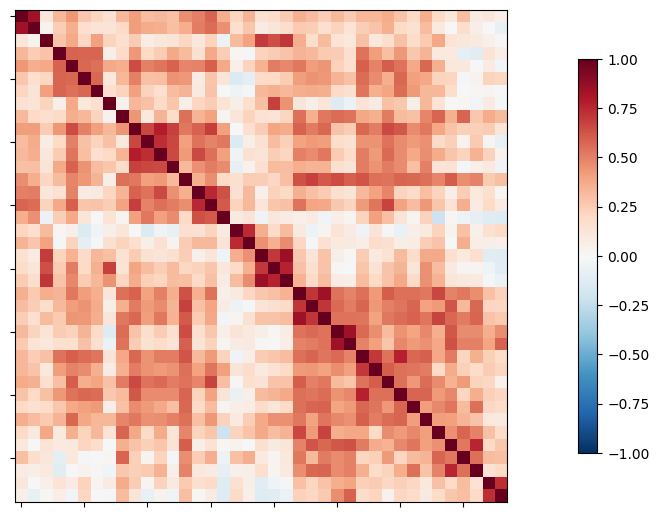

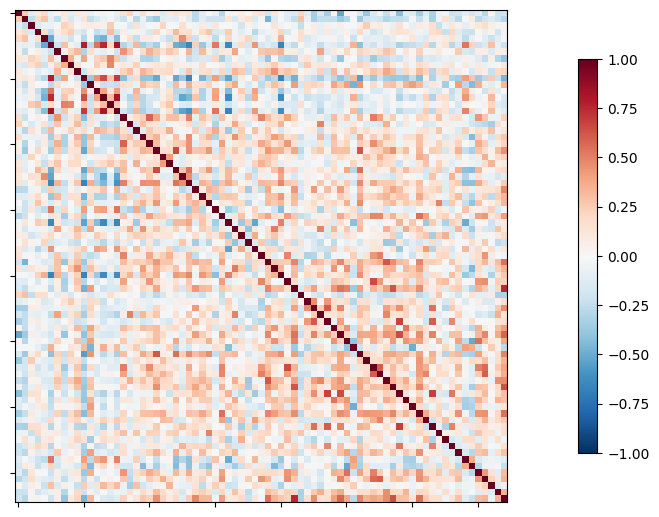

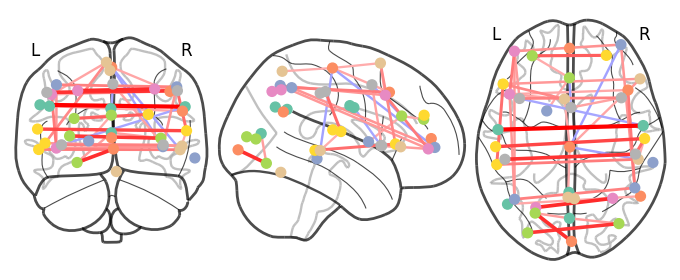

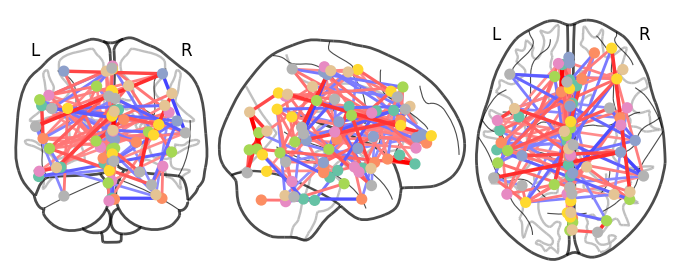

In [6]:
# Plot partial correlation matrix for one subject
plotting.plot_matrix(corr_matrices_1[20], colorbar=True, vmax=1, vmin=-1)
plotting.plot_matrix(corr_matrices_2[20], colorbar=True, vmax=1, vmin=-1)

# Plot brain connectome for one subject
atlas_coords = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas_1.maps)
plotting.plot_connectome(pcorr_matrices_1[20], atlas_coords, edge_threshold="95%")

atlas_coords = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas_2.maps)
plotting.plot_connectome(pcorr_matrices_2[20], atlas_coords, edge_threshold="95%")

In [7]:
class GraphPhenoDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, phenotypic_data=None, neighbor_ratio=0.1):
        self.neighbor_ratio = neighbor_ratio
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        """ Converts raw data into GNN-readable format by constructing
        graphs out of connectivity matrices.
        """

        # Paths of connectivity matrices
        corr_path_list = sorted(os.listdir(corr_matrices_dirs[0]), key=lambda x: int(x[-8:-4]))
        pcorr_path_list = sorted(os.listdir(pcorr_matrices_dirs[0]), key=lambda x: int(x[-8:-4]))

        graphs = []
        phenotypic_data = np.loadtxt(phenotypic_file, delimiter=',')
        labels = torch.from_numpy(phenotypic_data[:, 0])
        age = torch.from_numpy(phenotypic_data[:, 1])
        sex = torch.from_numpy(phenotypic_data[:, 2])

        for i in range(0, len(corr_path_list)):
            corr_matrix_path = os.path.join(corr_matrices_dirs[0], corr_path_list[i])
            pcorr_matrix_path = os.path.join(pcorr_matrices_dirs[0], pcorr_path_list[i])

            # Load partial correlation matrices
            pcorr_matrix_np = np.loadtxt(pcorr_matrix_path, delimiter=',')

            index = np.abs(pcorr_matrix_np).argsort(axis=1)
            n_rois = pcorr_matrix_np.shape[0]

            # Take top k correlates (k = n_subjects * neighbor_ratio) as edges
            for j in range(n_rois):
                for k in range(n_rois - int(self.neighbor_ratio*n_rois)):
                    pcorr_matrix_np[j, index[j, k]] = 0
                #for k in range(n_rois - int(self.neighbor_ratio*n_rois), n_rois):
                    #pcorr_matrix_np[j, index[j, k]] = 1

            pcorr_matrix_nx = from_numpy_array(pcorr_matrix_np)
            pcorr_matrix_data = from_networkx(pcorr_matrix_nx)

            # Correlation matrix which will serve as our features
            corr_matrix_np = np.loadtxt(corr_matrix_path, delimiter=',')

            pcorr_matrix_data.x = torch.tensor(corr_matrix_np).float()
            pcorr_matrix_data.y = labels[i].type(torch.LongTensor)
            pcorr_matrix_data.age = age[i].type(torch.FloatTensor)
            pcorr_matrix_data.sex = sex[i].type(torch.FloatTensor)

            # Add to running list of all dataset items
            graphs.append(pcorr_matrix_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

class MultiGraphDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, neighbor_ratio=0.1):
        self.neighbor_ratio = neighbor_ratio
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        """ Converts raw data into GNN-readable format by constructing
        graphs out of connectivity matrices.
        """

        # Paths of connectivity matrices
        corr_path_lists = []
        pcorr_path_lists = []
        
        corr_path_lists.append(sorted(os.listdir(corr_matrices_dirs[0]), key=lambda x: int(x[-8:-4])))
        corr_path_lists.append(sorted(os.listdir(corr_matrices_dirs[1]), key=lambda x: int(x[-8:-4])))

        pcorr_path_lists.append(sorted(os.listdir(pcorr_matrices_dirs[0]), key=lambda x: int(x[-8:-4])))
        pcorr_path_lists.append(sorted(os.listdir(pcorr_matrices_dirs[1]), key=lambda x: int(x[-8:-4])))

        phenotypic_data = np.loadtxt(phenotypic_file, delimiter=',')
        labels = torch.from_numpy(phenotypic_data[:, 0])
        age = torch.from_numpy(phenotypic_data[:, 1])
        sex = torch.from_numpy(phenotypic_data[:, 2])

        data_list = []

        for i in range(0, n_subjects):
            graphs = []

            for graph_i in range(2):
                corr_matrix_path = os.path.join(corr_matrices_dirs[graph_i], corr_path_lists[graph_i][i])
                pcorr_matrix_path = os.path.join(pcorr_matrices_dirs[graph_i], pcorr_path_lists[graph_i][i])

                # Load partial correlation matrices
                pcorr_matrix_np = np.loadtxt(pcorr_matrix_path, delimiter=',')

                index = np.abs(pcorr_matrix_np).argsort(axis=1)
                n_rois = pcorr_matrix_np.shape[0]

                # Take top k correlates (k = n_subjects * neighbor_ratio) as edges
                for j in range(n_rois):
                    for k in range(n_rois - int(self.neighbor_ratio*n_rois)):
                        pcorr_matrix_np[j, index[j, k]] = 0
                    #for k in range(n_rois - int(self.neighbor_ratio*n_rois), n_rois):
                        #pcorr_matrix_np[j, index[j, k]] = 1

                pcorr_matrix_nx = from_numpy_array(pcorr_matrix_np)
                pcorr_matrix_data = from_networkx(pcorr_matrix_nx)

                # Correlation matrix which will serve as our features
                corr_matrix_np = np.loadtxt(corr_matrix_path, delimiter=',')

                pcorr_matrix_data.x = torch.tensor(corr_matrix_np).float()
                pcorr_matrix_data.y = labels[i].type(torch.LongTensor)

                # Add to running list of all dataset items
                graphs.append(pcorr_matrix_data)
        
            data = Data(x1 = graphs[0].x, edge_index1 = graphs[0].edge_index,
                        x2 = graphs[1].x, edge_index2 = graphs[1].edge_index,
                        num_nodes1 = graphs[0].num_nodes, num_nodes2 = graphs[1].num_nodes, 
                        age = age[i].type(torch.FloatTensor), sex = sex[i].type(torch.FloatTensor),
                        y = graphs[0].y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

For the below, run one of the two cells to create either a multigraph dataset (MultiGraphDataset) or single graph dataset (GraphPhenoDataset).

In [8]:
# Run this for multigraph dataset

dataset = MultiGraphDataset(f'multigraph_{atlas_1_name}_{atlas_2_name}')
dataset = dataset.shuffle()

# Train/test split (80-20)
train_share = int(len(dataset) * 0.8)

train_dataset = dataset[:train_share]
test_dataset = dataset[train_share:]

In [42]:
# Run this for single graph dataset

dataset = GraphPhenoDataset(f'graph_{atlas_1_name}')
dataset = dataset.shuffle()

# Train/test split (80-20)
train_share = int(len(dataset) * 0.8)

train_dataset = dataset[:train_share]
test_dataset = dataset[train_share:]

## Graph Neural Network

In [9]:
class GraphNetwork_Pheno(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        # Initialize MLPs used by EdgeConv layers
        self.mlp1 = Sequential(Linear(2 * dataset.num_node_features, hidden_channels), ReLU())
        self.mlp2 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())

        # Initialize EdgeConv layers
        self.conv1 = EdgeConv(self.mlp1, aggr='max')
        self.conv2 = EdgeConv(self.mlp2, aggr='max')

        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)

        self.lin1 = torch.nn.Linear(hidden_channels + 2, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        """ Performs a forward pass on our simplified cGCN.

        Parameters:
        data (Data): Graph being passed into network.

        Returns:
        torch.Tensor (N x 2): Probability distribution over class labels.
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        age = data.age
        sex = data.sex

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        
        x = torch.cat((x, age.unsqueeze(1), sex.unsqueeze(1)), 1)
        x = self.lin1(x)
        x = F.relu(x)        
        x = self.lin2(x)

        x = F.softmax(x, dim=1)

        return x

class GraphNetwork_Multi(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1_1 = GCNConv(dataset[0].x1.shape[0], hidden_channels)
        self.conv2_1 = GCNConv(hidden_channels, hidden_channels)
        self.bn1_1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2_1 = torch.nn.BatchNorm1d(hidden_channels)

        self.conv1_2 = GCNConv(dataset[0].x2.shape[0], hidden_channels)
        self.conv2_2 = GCNConv(hidden_channels, hidden_channels)

        self.bn1_2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2_2 = torch.nn.BatchNorm1d(hidden_channels)

        self.lin1 = torch.nn.Linear(hidden_channels * 2 + 2, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        """ Performs a forward pass on our simplified cGCN.

        Parameters:
        data (Data): Graph being passed into network.

        Returns:
        torch.Tensor (N x 2): Probability distribution over class labels.
        """
        x1, x2 = data.x1, data.x2
        edge_index1, edge_index2 = data.edge_index1, data.edge_index2
        batch = data.batch
        age = data.age
        sex = data.sex

        # Process graph 1
        x1 = F.relu(self.bn1_1(self.conv1_1(x1, edge_index1)))
        x1 = F.relu(self.bn2_1(self.conv2_1(x1, edge_index1)))
        x1_batch, _ = torch.sort(torch.tile(batch, (int(len(x1)/len(batch)),)))
        x1 = global_mean_pool(x1, x1_batch)  # Aggregate node features to graph features

        # Process graph 2
        x2 = F.relu(self.bn1_2(self.conv1_2(x2, edge_index2)))
        x2 = F.relu(self.bn2_2(self.conv2_2(x2, edge_index2)))
        x2_batch, _ = torch.sort(torch.tile(batch, (int(len(x2)/len(batch)),)))
        x2 = global_mean_pool(x2, x2_batch)  # Aggregate node features to graph features

        # Concatenate features from both graphs and classify
        x = torch.cat((x1, x2, age.unsqueeze(1), sex.unsqueeze(1)), dim=1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))

        x = F.softmax(x, dim=1)

        return x

In [10]:
def train(model, loss_fn, device, data_loader, optimizer):
    """ 
    Performs an epoch of model training.
    """
    model.train()
    loss = 0

    for batch in data_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch)

        loss = loss_fn(out, batch.y)

        loss.backward()
        optimizer.step()

    return loss.item()

def eval(model, device, loader):
    """
    Calculate accuracy for all examples in a DataLoader.
    """
    model.eval()
    cor = 0
    tot = 0

    for batch in loader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)

        y = batch.y
        cor += (pred == y).sum()
        tot += pred.shape[0]

    return cor, tot

def eval_precision(model, device, loader):
    """ 
    Calculate accuracy, precision, recall for all examples in a DataLoader.
    """
    model.eval()
    TP, FP, TN, FN = 0.01, 0.01, 0.01, 0.01
    
    for batch in loader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)
        
        for pred_i in range(len(pred)):
            if pred[pred_i]==0 and batch.y[pred_i]==0:
                TP += 1
            elif pred[pred_i]==0 and batch.y[pred_i]==1:
                FP += 1
            elif pred[pred_i]==1 and batch.y[pred_i]==1:
                TN += 1
            else:
                FN += 1

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = (TP) / (TP + FP)    
    recall = (TP) / (TP + FN)

    return accuracy, precision, recall


### Multiscale GNN

Epoch: 01, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 02, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 03, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 04, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 05, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 06, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 07, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 08, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 09, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 10, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 11, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 12, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 13, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 14, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 15, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 16, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 17, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 18, Loss: -0.5000, Train: 48.39%, Test: 50.00%
Epoch: 19, Loss: -0.5000, Tr

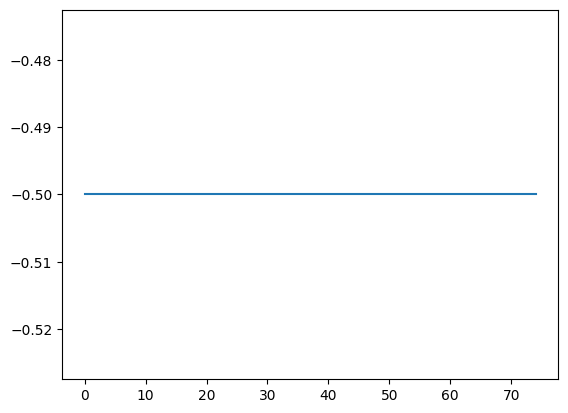

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphNetwork_Multi(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loss_fn = torch.nn.NLLLoss()
losses = []

for epoch in range(0, 75):
    loss = train(model, loss_fn, device, train_loader, optimizer)
    train_correct, train_samples = eval(model, device, train_loader)
    test_correct, test_samples = eval(model, device, test_loader)

    losses.append(loss)

    print(f'Epoch: {epoch + 1:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_correct / train_samples:.2f}%, '
          f'Test: {100 * test_correct / test_samples:.2f}%')

plt.plot(losses)
plt.show()

In [12]:
n_epochs = 75
batch_size = 32
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True)
fold_accuracy = []
fold_precision = []
fold_recall = []
fold_time = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Training fold {fold+1}/{n_splits}")

    # Create data subsets for the current fold
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    start_time = time.time()
    # Initialize the model
    model = GraphNetwork_Multi(32).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = torch.nn.NLLLoss()

    for epoch in range(n_epochs):
        loss = train(model, loss_fn, device, train_loader, optimizer)
        tot_correct, tot_samples = eval(model, device, val_loader)
        accuracy, precision, recall = eval_precision(model, device, val_loader)
        print(f"Epoch {epoch+1}: Fold {fold+1} Validation Accuracy: {accuracy:.4f}")
    
    end_time = time.time()
    
    fold_accuracy.append(accuracy)
    fold_precision.append(precision)
    fold_recall.append(recall)
    fold_time.append(end_time - start_time)

average_accuracy = np.mean(fold_accuracy)
print(f"Average Cross-Validation Accuracy: {average_accuracy:.4f}")

Training fold 1/5
Epoch 1: Fold 1 Validation Accuracy: 0.3753
Epoch 2: Fold 1 Validation Accuracy: 0.3753
Epoch 3: Fold 1 Validation Accuracy: 0.3753
Epoch 4: Fold 1 Validation Accuracy: 0.3753
Epoch 5: Fold 1 Validation Accuracy: 0.3753
Epoch 6: Fold 1 Validation Accuracy: 0.3753
Epoch 7: Fold 1 Validation Accuracy: 0.3753
Epoch 8: Fold 1 Validation Accuracy: 0.3753
Epoch 9: Fold 1 Validation Accuracy: 0.3753
Epoch 10: Fold 1 Validation Accuracy: 0.3753
Epoch 11: Fold 1 Validation Accuracy: 0.3753
Epoch 12: Fold 1 Validation Accuracy: 0.3753
Epoch 13: Fold 1 Validation Accuracy: 0.3753
Epoch 14: Fold 1 Validation Accuracy: 0.3753
Epoch 15: Fold 1 Validation Accuracy: 0.3753
Epoch 16: Fold 1 Validation Accuracy: 0.3753
Epoch 17: Fold 1 Validation Accuracy: 0.3753
Epoch 18: Fold 1 Validation Accuracy: 0.3753
Epoch 19: Fold 1 Validation Accuracy: 0.3753
Epoch 20: Fold 1 Validation Accuracy: 0.3753
Epoch 21: Fold 1 Validation Accuracy: 0.3753
Epoch 22: Fold 1 Validation Accuracy: 0.3753
E

In [13]:
sparsity_list = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

sparsity_accuracy = []
sparsity_precision = []
sparsity_recall = []
sparsity_time = []

for sparsity_i, sparsity in enumerate(sparsity_list):    
    dataset_sparsity = MultiGraphDataset(f'multigraph_sparsity_test', neighbor_ratio=sparsity)

    n_epochs = 75
    batch_size = 32
    n_splits = 5

    kf = KFold(n_splits=n_splits, shuffle=True)
    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_time = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_sparsity)):
        print(f"Training fold {fold+1}/{n_splits}")

        # Create data subsets for the current fold
        train_subset = torch.utils.data.Subset(dataset_sparsity, train_idx)
        val_subset = torch.utils.data.Subset(dataset_sparsity, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        start_time = time.time()
        # Initialize the model
        model = GraphNetwork_Multi(32).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        loss_fn = torch.nn.NLLLoss()

        for epoch in range(n_epochs):
            loss = train(model, loss_fn, device, train_loader, optimizer)
            tot_correct, tot_samples = eval(model, device, val_loader)
            accuracy, precision, recall = eval_precision(model, device, val_loader)
            print(f"Epoch {epoch+1}: Fold {fold+1} Validation Accuracy: {accuracy:.4f}") 
        end_time = time.time()

        fold_accuracy.append(accuracy)
        fold_precision.append(precision)
        fold_recall.append(recall)
        fold_time.append(end_time - start_time)

    sparsity_accuracy.append(fold_accuracy)
    sparsity_precision.append(fold_precision)
    sparsity_recall.append(fold_recall)
    sparsity_time.append(fold_time)
    
    shutil.rmtree('multigraph_sparsity_test')

Processing...
Done!


Training fold 1/5
Epoch 1: Fold 1 Validation Accuracy: 0.5486
Epoch 2: Fold 1 Validation Accuracy: 0.5486
Epoch 3: Fold 1 Validation Accuracy: 0.5486
Epoch 4: Fold 1 Validation Accuracy: 0.5486
Epoch 5: Fold 1 Validation Accuracy: 0.5714
Epoch 6: Fold 1 Validation Accuracy: 0.5886
Epoch 7: Fold 1 Validation Accuracy: 0.6285
Epoch 8: Fold 1 Validation Accuracy: 0.6400
Epoch 9: Fold 1 Validation Accuracy: 0.6457
Epoch 10: Fold 1 Validation Accuracy: 0.6400
Epoch 11: Fold 1 Validation Accuracy: 0.6114
Epoch 12: Fold 1 Validation Accuracy: 0.5714
Epoch 13: Fold 1 Validation Accuracy: 0.6057
Epoch 14: Fold 1 Validation Accuracy: 0.5600
Epoch 15: Fold 1 Validation Accuracy: 0.6457
Epoch 16: Fold 1 Validation Accuracy: 0.6000
Epoch 17: Fold 1 Validation Accuracy: 0.6514
Epoch 18: Fold 1 Validation Accuracy: 0.5714
Epoch 19: Fold 1 Validation Accuracy: 0.6571
Epoch 20: Fold 1 Validation Accuracy: 0.6685
Epoch 21: Fold 1 Validation Accuracy: 0.6571
Epoch 22: Fold 1 Validation Accuracy: 0.6114
E

Processing...
Done!


Training fold 1/5
Epoch 1: Fold 1 Validation Accuracy: 0.5543
Epoch 2: Fold 1 Validation Accuracy: 0.5543
Epoch 3: Fold 1 Validation Accuracy: 0.5543
Epoch 4: Fold 1 Validation Accuracy: 0.5886
Epoch 5: Fold 1 Validation Accuracy: 0.6171
Epoch 6: Fold 1 Validation Accuracy: 0.5657
Epoch 7: Fold 1 Validation Accuracy: 0.5714
Epoch 8: Fold 1 Validation Accuracy: 0.5771
Epoch 9: Fold 1 Validation Accuracy: 0.5714
Epoch 10: Fold 1 Validation Accuracy: 0.5600
Epoch 11: Fold 1 Validation Accuracy: 0.5886
Epoch 12: Fold 1 Validation Accuracy: 0.5828
Epoch 13: Fold 1 Validation Accuracy: 0.5714
Epoch 14: Fold 1 Validation Accuracy: 0.5714
Epoch 15: Fold 1 Validation Accuracy: 0.5543
Epoch 16: Fold 1 Validation Accuracy: 0.6057
Epoch 17: Fold 1 Validation Accuracy: 0.5943
Epoch 18: Fold 1 Validation Accuracy: 0.5486
Epoch 19: Fold 1 Validation Accuracy: 0.5600
Epoch 20: Fold 1 Validation Accuracy: 0.5543
Epoch 21: Fold 1 Validation Accuracy: 0.5428
Epoch 22: Fold 1 Validation Accuracy: 0.5714
E

Processing...
Done!


Training fold 1/5
Epoch 1: Fold 1 Validation Accuracy: 0.4572
Epoch 2: Fold 1 Validation Accuracy: 0.4572
Epoch 3: Fold 1 Validation Accuracy: 0.4572
Epoch 4: Fold 1 Validation Accuracy: 0.4572
Epoch 5: Fold 1 Validation Accuracy: 0.4572
Epoch 6: Fold 1 Validation Accuracy: 0.4572
Epoch 7: Fold 1 Validation Accuracy: 0.4572
Epoch 8: Fold 1 Validation Accuracy: 0.4572
Epoch 9: Fold 1 Validation Accuracy: 0.4572
Epoch 10: Fold 1 Validation Accuracy: 0.4572
Epoch 11: Fold 1 Validation Accuracy: 0.4572
Epoch 12: Fold 1 Validation Accuracy: 0.4572
Epoch 13: Fold 1 Validation Accuracy: 0.4572
Epoch 14: Fold 1 Validation Accuracy: 0.4572
Epoch 15: Fold 1 Validation Accuracy: 0.4572
Epoch 16: Fold 1 Validation Accuracy: 0.4572
Epoch 17: Fold 1 Validation Accuracy: 0.4572
Epoch 18: Fold 1 Validation Accuracy: 0.4572
Epoch 19: Fold 1 Validation Accuracy: 0.4572
Epoch 20: Fold 1 Validation Accuracy: 0.4572
Epoch 21: Fold 1 Validation Accuracy: 0.4572
Epoch 22: Fold 1 Validation Accuracy: 0.4572
E

Processing...
Done!


Training fold 1/5
Epoch 1: Fold 1 Validation Accuracy: 0.4572
Epoch 2: Fold 1 Validation Accuracy: 0.5486
Epoch 3: Fold 1 Validation Accuracy: 0.5428
Epoch 4: Fold 1 Validation Accuracy: 0.5828
Epoch 5: Fold 1 Validation Accuracy: 0.6343
Epoch 6: Fold 1 Validation Accuracy: 0.6228
Epoch 7: Fold 1 Validation Accuracy: 0.5828
Epoch 8: Fold 1 Validation Accuracy: 0.6228
Epoch 9: Fold 1 Validation Accuracy: 0.6628
Epoch 10: Fold 1 Validation Accuracy: 0.6571
Epoch 11: Fold 1 Validation Accuracy: 0.6571
Epoch 12: Fold 1 Validation Accuracy: 0.6228
Epoch 13: Fold 1 Validation Accuracy: 0.6571
Epoch 14: Fold 1 Validation Accuracy: 0.6171
Epoch 15: Fold 1 Validation Accuracy: 0.6514
Epoch 16: Fold 1 Validation Accuracy: 0.6343
Epoch 17: Fold 1 Validation Accuracy: 0.6514
Epoch 18: Fold 1 Validation Accuracy: 0.6457
Epoch 19: Fold 1 Validation Accuracy: 0.6343
Epoch 20: Fold 1 Validation Accuracy: 0.5657
Epoch 21: Fold 1 Validation Accuracy: 0.6228
Epoch 22: Fold 1 Validation Accuracy: 0.5428
E

Processing...
Done!


Training fold 1/5
Epoch 1: Fold 1 Validation Accuracy: 0.4514
Epoch 2: Fold 1 Validation Accuracy: 0.4514
Epoch 3: Fold 1 Validation Accuracy: 0.4514
Epoch 4: Fold 1 Validation Accuracy: 0.4514
Epoch 5: Fold 1 Validation Accuracy: 0.4514
Epoch 6: Fold 1 Validation Accuracy: 0.4514
Epoch 7: Fold 1 Validation Accuracy: 0.4514
Epoch 8: Fold 1 Validation Accuracy: 0.4514
Epoch 9: Fold 1 Validation Accuracy: 0.4514
Epoch 10: Fold 1 Validation Accuracy: 0.4514
Epoch 11: Fold 1 Validation Accuracy: 0.4514
Epoch 12: Fold 1 Validation Accuracy: 0.4514
Epoch 13: Fold 1 Validation Accuracy: 0.4514
Epoch 14: Fold 1 Validation Accuracy: 0.4514
Epoch 15: Fold 1 Validation Accuracy: 0.4514
Epoch 16: Fold 1 Validation Accuracy: 0.4514
Epoch 17: Fold 1 Validation Accuracy: 0.4514
Epoch 18: Fold 1 Validation Accuracy: 0.4514
Epoch 19: Fold 1 Validation Accuracy: 0.4514
Epoch 20: Fold 1 Validation Accuracy: 0.4514
Epoch 21: Fold 1 Validation Accuracy: 0.4514
Epoch 22: Fold 1 Validation Accuracy: 0.4514
E

Processing...
Done!


Training fold 1/5
Epoch 1: Fold 1 Validation Accuracy: 0.5371
Epoch 2: Fold 1 Validation Accuracy: 0.5371
Epoch 3: Fold 1 Validation Accuracy: 0.5371
Epoch 4: Fold 1 Validation Accuracy: 0.5371
Epoch 5: Fold 1 Validation Accuracy: 0.5371
Epoch 6: Fold 1 Validation Accuracy: 0.5371
Epoch 7: Fold 1 Validation Accuracy: 0.5543
Epoch 8: Fold 1 Validation Accuracy: 0.6000
Epoch 9: Fold 1 Validation Accuracy: 0.5771
Epoch 10: Fold 1 Validation Accuracy: 0.5600
Epoch 11: Fold 1 Validation Accuracy: 0.5828
Epoch 12: Fold 1 Validation Accuracy: 0.6114
Epoch 13: Fold 1 Validation Accuracy: 0.5828
Epoch 14: Fold 1 Validation Accuracy: 0.5943
Epoch 15: Fold 1 Validation Accuracy: 0.5543
Epoch 16: Fold 1 Validation Accuracy: 0.5657
Epoch 17: Fold 1 Validation Accuracy: 0.6285
Epoch 18: Fold 1 Validation Accuracy: 0.5828
Epoch 19: Fold 1 Validation Accuracy: 0.6000
Epoch 20: Fold 1 Validation Accuracy: 0.5543
Epoch 21: Fold 1 Validation Accuracy: 0.6285
Epoch 22: Fold 1 Validation Accuracy: 0.6171
E

In [31]:
feature_importances = []

for i in range(train_dataset[0]['x1'].shape[1]):
    occluded_data = test_dataset.copy()
    for data in occluded_data:
        data['x1'][:, i] = 0
    
    occluded_loader = DataLoader(occluded_data, batch_size=32, shuffle=False)
    original_output = eval_precision(model, device, test_loader)
    occluded_output = eval_precision(model, device, occluded_loader)

    output_change = occluded_output[0] - original_output[0]
    feature_importances.append(output_change)

In [40]:
key_ROI_indices = [int(i) for i in list(np.argsort(feature_importances)[:10])]
print(key_ROI_indices)

[0, 21, 22, 23, 24, 25, 26, 27, 20, 28]


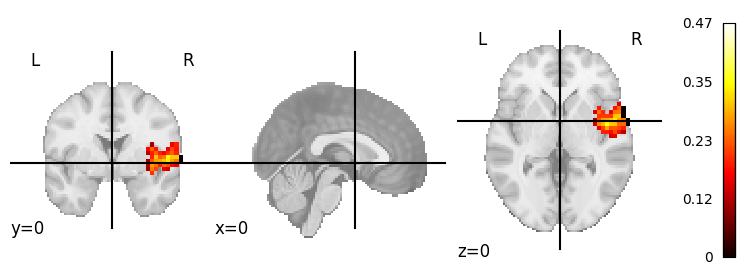

In [41]:
# Select a specific network to plot
selected_network_img = image.index_img(atlas_1.maps, 26)  # Change index for network

# Plotting
plotting.plot_stat_map(selected_network_img, display_mode='ortho', cut_coords=(0, 0, 0))
plotting.show()

### Single Graph GNN

/root/anaconda3/envs/GNN/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 01, Loss: -0.6675, Train: 53.74%, Test: 53.71%
Epoch: 02, Loss: -0.7052, Train: 53.74%, Test: 53.71%
Epoch: 03, Loss: -0.4576, Train: 53.74%, Test: 53.71%
Epoch: 04, Loss: -0.5397, Train: 53.74%, Test: 53.71%
Epoch: 05, Loss: -0.6121, Train: 53.74%, Test: 53.71%
Epoch: 06, Loss: -0.5823, Train: 55.03%, Test: 54.29%
Epoch: 07, Loss: -0.7197, Train: 66.09%, Test: 58.29%
Epoch: 08, Loss: -0.7196, Train: 59.48%, Test: 52.57%
Epoch: 09, Loss: -0.6643, Train: 65.66%, Test: 57.14%
Epoch: 10, Loss: -0.7467, Train: 73.28%, Test: 62.86%
Epoch: 11, Loss: -0.7267, Train: 76.87%, Test: 59.43%
Epoch: 12, Loss: -0.7415, Train: 69.40%, Test: 61.14%
Epoch: 13, Loss: -0.8450, Train: 65.23%, Test: 58.86%
Epoch: 14, Loss: -0.8557, Train: 69.83%, Test: 57.14%
Epoch: 15, Loss: -0.8679, Train: 84.05%, Test: 61.71%
Epoch: 16, Loss: -0.6118, Train: 83.48%, Test: 56.57%
Epoch: 17, Loss: -0.8577, Train: 78.02%, Test: 57.14%
Epoch: 18, Loss: -0.8715, Train: 82.61%, Test: 62.86%
Epoch: 19, Loss: -0.7970, Tr

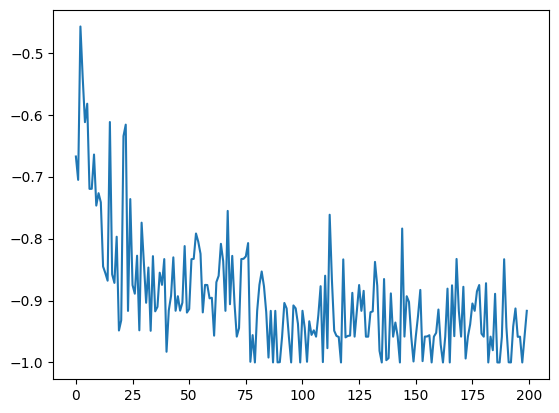

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphNetwork_Pheno(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loss_fn = torch.nn.NLLLoss()
losses = []

for epoch in range(0, 200):
    loss = train(model, loss_fn, device, train_loader, optimizer)
    train_correct, train_samples = eval(model, device, train_loader)
    test_correct, test_samples = eval(model, device, test_loader)

    losses.append(loss)

    print(f'Epoch: {epoch + 1:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_correct / train_samples:.2f}%, '
          f'Test: {100 * test_correct / test_samples:.2f}%')

plt.plot(losses)
plt.show()

## Shallow Embedding followed by SVM

In [44]:
def train_node2vec(model, loader, optimizer):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def embed_node2vec(dataset, epochs=30, p_in=1, q_in=1):
    # Set model
    data = dataset
    model = Node2Vec(data.edge_index, embedding_dim=16, walk_length=10,
                     context_size=8, walks_per_node=10,
                     num_negative_samples=1, p=p_in, q=q_in, sparse=True).to(device)
    loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

    # Train model
    for epoch in range(1, epochs+1):
        loss = train_node2vec(model, loader, optimizer)
        if epoch%10 == 0:
            print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    
    return model.embedding.weight.data.cpu().numpy().flatten()

In [45]:
graph_embeddings = []
labels = []

for data_i, data in enumerate(dataset[:50]):
    print('subject:', data_i)
    embedding = embed_node2vec(data, epochs=200, p_in=1, q_in=1)
    graph_embeddings.append(embedding)
    labels.append(data.y.item())

graph_embeddings = np.array(graph_embeddings)
labels = np.array(labels)

subject: 0
Epoch: 10, Loss: 2.9845
Epoch: 20, Loss: 2.5446
Epoch: 30, Loss: 2.1121
Epoch: 40, Loss: 1.9599
Epoch: 50, Loss: 1.7503
Epoch: 60, Loss: 1.5647
Epoch: 70, Loss: 1.4441
Epoch: 80, Loss: 1.3966
Epoch: 90, Loss: 1.3095
Epoch: 100, Loss: 1.2854
Epoch: 110, Loss: 1.2714
Epoch: 120, Loss: 1.2031
Epoch: 130, Loss: 1.2022
Epoch: 140, Loss: 1.1641
Epoch: 150, Loss: 1.1404
Epoch: 160, Loss: 1.1398
Epoch: 170, Loss: 1.1091
Epoch: 180, Loss: 1.1129
Epoch: 190, Loss: 1.0702
Epoch: 200, Loss: 1.0926
subject: 1
Epoch: 10, Loss: 3.0487
Epoch: 20, Loss: 2.5399
Epoch: 30, Loss: 2.2277
Epoch: 40, Loss: 1.9874
Epoch: 50, Loss: 1.7534
Epoch: 60, Loss: 1.5660
Epoch: 70, Loss: 1.4819
Epoch: 80, Loss: 1.3885
Epoch: 90, Loss: 1.3308
Epoch: 100, Loss: 1.2981
Epoch: 110, Loss: 1.2400
Epoch: 120, Loss: 1.2044
Epoch: 130, Loss: 1.1603
Epoch: 140, Loss: 1.1640
Epoch: 150, Loss: 1.1780
Epoch: 160, Loss: 1.1356
Epoch: 170, Loss: 1.1063
Epoch: 180, Loss: 1.1077
Epoch: 190, Loss: 1.1084
Epoch: 200, Loss: 1.1

In [46]:
X_train, X_test, y_train, y_test = train_test_split(graph_embeddings, labels, test_size=0.2)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

predictions = svm.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy of SVM on graph embeddings:", accuracy)

Accuracy of SVM on graph embeddings: 0.7


## Convolutional Neural Network

In [47]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Convert data into PyTorch tensors
X_reshaped = np.expand_dims(corr_matrices_1, axis=1)
X_tensor = torch.Tensor(X_reshaped) 
y_tensor = torch.Tensor(phenotypic_data_1[:,0]).long()

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

# Create DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Define the CNN
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) 
        self.relu = nn.ReLU()

        self.feature_size = 64 * (height // 4) * (width // 4)
        self.fc1 = nn.Linear(self.feature_size, 100)
        self.fc2 = nn.Linear(100, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.feature_size)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

# Initialize the CNN
height = 39
width = 39
num_classes = 2
model = CNN(num_classes).cuda()

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()  # Move to GPU if available
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6929194331169128
Epoch 2, Loss: 0.7049696445465088
Epoch 3, Loss: 0.7381872534751892
Epoch 4, Loss: 0.7550041079521179
Epoch 5, Loss: 0.6920798420906067
Epoch 6, Loss: 0.7614197731018066
Epoch 7, Loss: 0.6255930066108704
Epoch 8, Loss: 0.6908805966377258
Epoch 9, Loss: 0.6544767022132874
Epoch 10, Loss: 0.6666178107261658


In [49]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 57.714285714285715%
